# Amazon Delivery Time Prediction with MLflow
This notebook covers the end-to-end process of predicting delivery times, from data cleaning and visualization to model training and experiment tracking using MLflow.

## 1. Setup and Library Imports

In [1]:
!pip install pandas numpy scikit-learn xgboost mlflow joblib requests matplotlib seaborn

import pandas as pd
import numpy as np
import requests
import time
import joblib
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

## 2. Data Loading, Cleaning, and Initial Feature Engineering
This section prepares the base dataset that all subsequent experiments will use.

In [4]:
# Load data
df = pd.read_csv('amazon_delivery.csv') # <-- Make sure to use your file name

# Clean column names
df.columns = df.columns.str.strip().str.lower()

# Drop rows with missing values in crucial columns
df.dropna(subset=['agent_rating', 'weather', 'traffic'], inplace=True)

# Correct data types
df['order_date'] = pd.to_datetime(df['order_date'], format='mixed')
df['order_time'] = pd.to_datetime(df['order_time'], errors='coerce').dt.time
df['pickup_time'] = pd.to_datetime(df['pickup_time'], errors='coerce').dt.time

# Haversine distance function
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371
    lat1_rad, lon1_rad, lat2_rad, lon2_rad = map(np.radians, [lat1, lon1, lat2, lon2])
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

df['distance_km'] = haversine_distance(df['store_latitude'], df['store_longitude'], df['drop_latitude'], df['drop_longitude'])

# Preparation time
df_time_non_null = df.dropna(subset=['order_time', 'pickup_time'])
order_datetime = pd.to_datetime(df_time_non_null['order_date'].astype(str) + ' ' + df_time_non_null['order_time'].astype(str))
picked_datetime = pd.to_datetime(df_time_non_null['order_date'].astype(str) + ' ' + df_time_non_null['pickup_time'].astype(str))
df['preparation_time_min'] = (picked_datetime - order_datetime).dt.total_seconds() / 60
df['preparation_time_min'].fillna(df['preparation_time_min'].median(), inplace=True)

# Date features
df['order_month'] = df['order_date'].dt.month
df['order_day'] = df['order_date'].dt.day
df['order_day_of_week'] = df['order_date'].dt.dayofweek
df['is_weekend'] = df['order_day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

print("Data cleaning and initial feature engineering complete.")
print("Shape of cleaned data:", df.shape)

Data cleaning and initial feature engineering complete.
Shape of cleaned data: (43594, 22)


## 3. Exploratory Data Analysis (EDA) & Visualization
Before training models, we visualize the data to understand distributions and relationships.

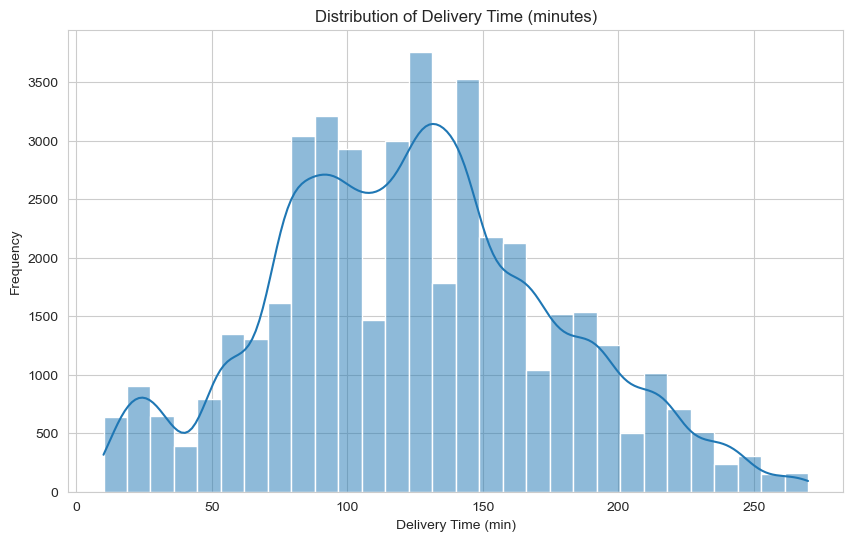

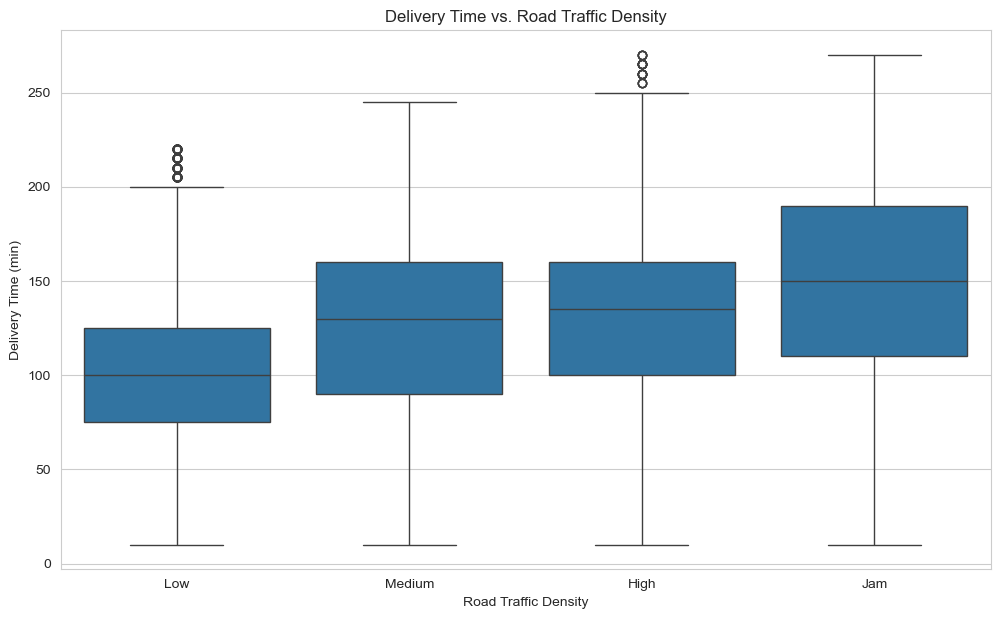

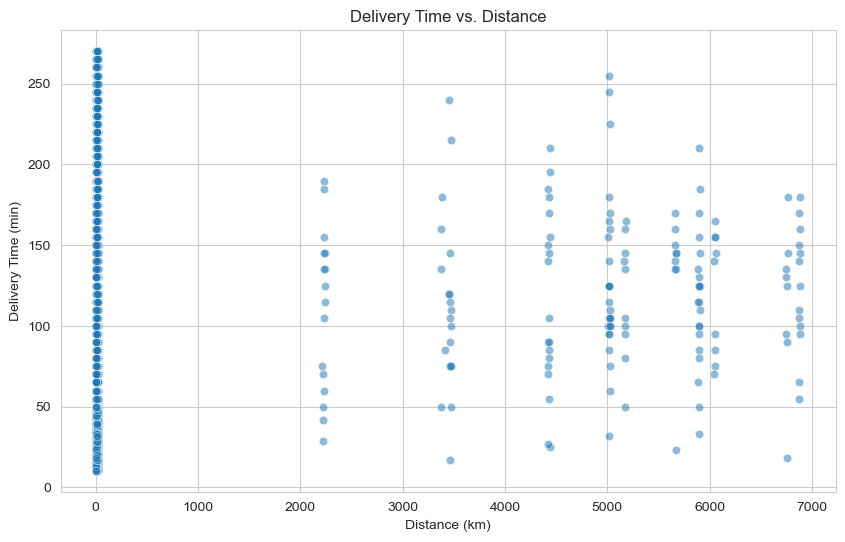

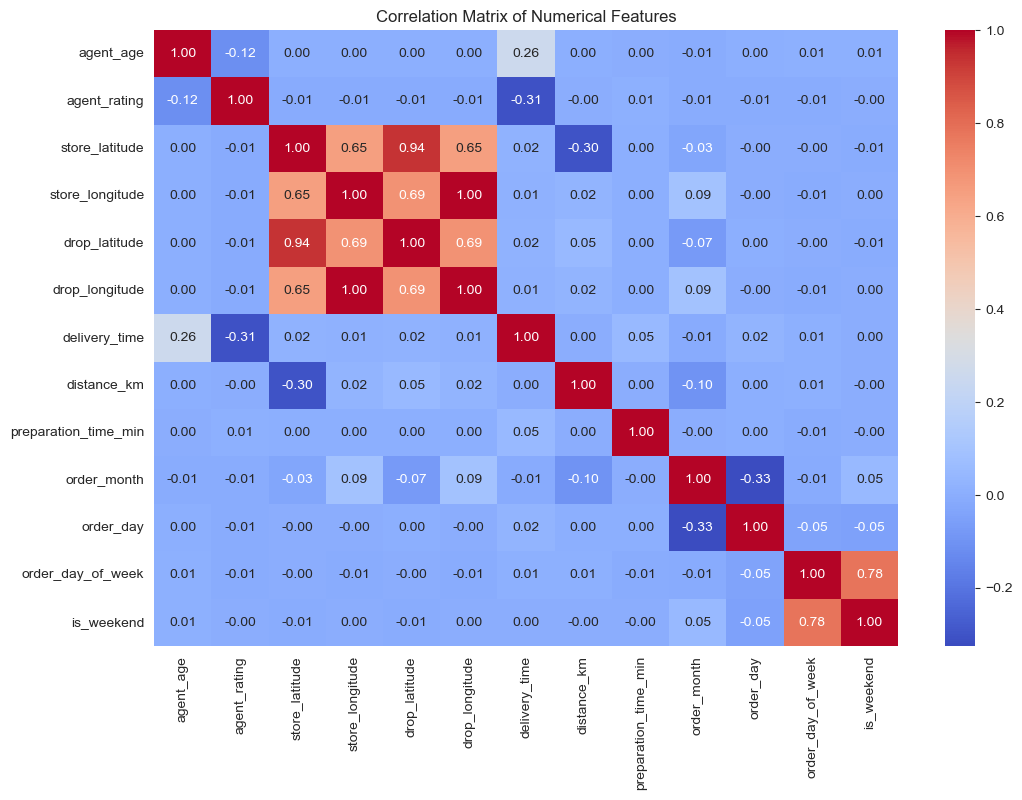

In [6]:
sns.set_style('whitegrid')

# --- FIX: Clean the data within categorical columns before plotting ---
df['traffic'] = df['traffic'].str.strip().str.title()
df['area'] = df['area'].str.strip().str.title()
# --------------------------------------------------------------------

# 1. Distribution of the Target Variable (Delivery Time)
plt.figure(figsize=(10, 6))
sns.histplot(df['delivery_time'], bins=30, kde=True)
plt.title('Distribution of Delivery Time (minutes)')
plt.xlabel('Delivery Time (min)')
plt.ylabel('Frequency')
plt.savefig('delivery_time_distribution.png')
plt.show()

# 2. Categorical Feature vs. Target (Traffic vs. Delivery Time)
plt.figure(figsize=(12, 7))
# This line will now work correctly
sns.boxplot(x='traffic', y='delivery_time', data=df, order=['Low', 'Medium', 'High', 'Jam'])
plt.title('Delivery Time vs. Road Traffic Density')
plt.xlabel('Road Traffic Density')
plt.ylabel('Delivery Time (min)')
plt.savefig('traffic_vs_time.png')
plt.show()

# 3. Numerical Feature vs. Target (Distance vs. Delivery Time)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='distance_km', y='delivery_time', data=df, alpha=0.5)
plt.title('Delivery Time vs. Distance')
plt.xlabel('Distance (km)')
plt.ylabel('Delivery Time (min)')
plt.savefig('distance_vs_time.png')
plt.show()

# 4. Correlation Heatmap for Numerical Features
plt.figure(figsize=(12, 8))
numerical_cols = df.select_dtypes(include=np.number)
corr = numerical_cols.corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.savefig('correlation_heatmap.png')
plt.show()

## 4. MLflow Experiment: Baseline Model Comparison
We train four models on the initial feature set and log their performance and the EDA plots to MLflow.

In [7]:
base_features = ['agent_age', 'agent_rating', 'distance_km', 'preparation_time_min', 'weather', 'traffic', 'vehicle', 'category', 'area', 'is_weekend']
target = 'delivery_time'
X = df[base_features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=np.number).columns
numeric_pipeline = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
preprocessor = ColumnTransformer(transformers=[('num', numeric_pipeline, numerical_features), ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_features)])

models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42)
}

mlflow.set_experiment("Delivery Time Prediction")
with mlflow.start_run(run_name="Baseline Model Comparison") as parent_run:
    mlflow.log_param("features", str(base_features))
    # Log the EDA plots as artifacts
    mlflow.log_artifact('delivery_time_distribution.png', artifact_path='eda_plots')
    mlflow.log_artifact('traffic_vs_time.png', artifact_path='eda_plots')
    mlflow.log_artifact('distance_vs_time.png', artifact_path='eda_plots')
    mlflow.log_artifact('correlation_heatmap.png', artifact_path='eda_plots')
    
    for name, model in models.items():
        with mlflow.start_run(run_name=name, nested=True) as nested_run:
            pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', model)])
            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict(X_test)

            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            mae = mean_absolute_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)

            mlflow.log_params(model.get_params())
            mlflow.log_metric("rmse", rmse)
            mlflow.log_metric("mae", mae)
            mlflow.log_metric("r2_score", r2)
            mlflow.sklearn.log_model(pipeline, "model")
            
            print(f"--- {name} Results ---")
            print(f"RMSE: {rmse:.2f} | MAE: {mae:.2f} | R2 Score: {r2:.3f}")

2025/10/05 20:01:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/05 20:01:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


--- Linear Regression Results ---
RMSE: 33.30 | MAE: 26.31 | R2 Score: 0.578


2025/10/05 20:05:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/05 20:05:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


--- Random Forest Results ---
RMSE: 23.13 | MAE: 17.65 | R2 Score: 0.797


2025/10/05 20:05:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/05 20:05:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


--- Gradient Boosting Results ---
RMSE: 25.17 | MAE: 19.54 | R2 Score: 0.759


2025/10/05 20:05:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/05 20:06:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


--- XGBoost Results ---
RMSE: 22.70 | MAE: 17.69 | R2 Score: 0.804


## 5. MLflow Experiment: Hyperparameter Tuning
We take our best baseline model (XGBoost) and use RandomizedSearchCV to find the optimal hyperparameters, logging the results.

In [8]:
with mlflow.start_run(run_name="Hyperparameter Tuning") as parent_run:
    param_grid = {
        'regressor__n_estimators': [100, 200, 300, 500],
        'regressor__max_depth': [3, 5, 7, 9],
        'regressor__learning_rate': [0.01, 0.05, 0.1],
        'regressor__subsample': np.arange(0.6, 1.0, 0.1),
        'regressor__colsample_bytree': np.arange(0.6, 1.0, 0.1)
    }
    
    xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', XGBRegressor(random_state=42, n_jobs=-1))])

    random_search = RandomizedSearchCV(
        estimator=xgb_pipeline,
        param_distributions=param_grid,
        n_iter=50,
        cv=5,
        scoring='neg_root_mean_squared_error',
        random_state=42,
        verbose=1
    )

    print("🚀 Starting hyperparameter tuning for XGBoost...")
    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_
    y_pred_tuned = best_model.predict(X_test)

    rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_tuned))
    mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
    r2_tuned = r2_score(y_test, y_pred_tuned)

    mlflow.log_param("model", "XGBoost")
    mlflow.log_params(random_search.best_params_)
    mlflow.log_metric("best_rmse", rmse_tuned)
    mlflow.log_metric("best_mae", mae_tuned)
    mlflow.log_metric("best_r2_score", r2_tuned)
    mlflow.sklearn.log_model(best_model, "tuned_xgboost_model")
    
    print("\n--- Tuned XGBoost Results ---")
    print(f"RMSE: {rmse_tuned:.2f} | MAE: {mae_tuned:.2f} | R2 Score: {r2_tuned:.3f}")

🚀 Starting hyperparameter tuning for XGBoost...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


2025/10/05 20:09:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/05 20:09:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



--- Tuned XGBoost Results ---
RMSE: 22.11 | MAE: 17.11 | R2 Score: 0.814


## Script to Visualize Outliers
You can add this as a new cell in your Jupyter notebook. It will loop through the most important numerical columns and create a separate box plot for each one.

📊 Visualizing Outliers in Key Numerical Features...
Data points shown as dots outside the main box whiskers are potential outliers.


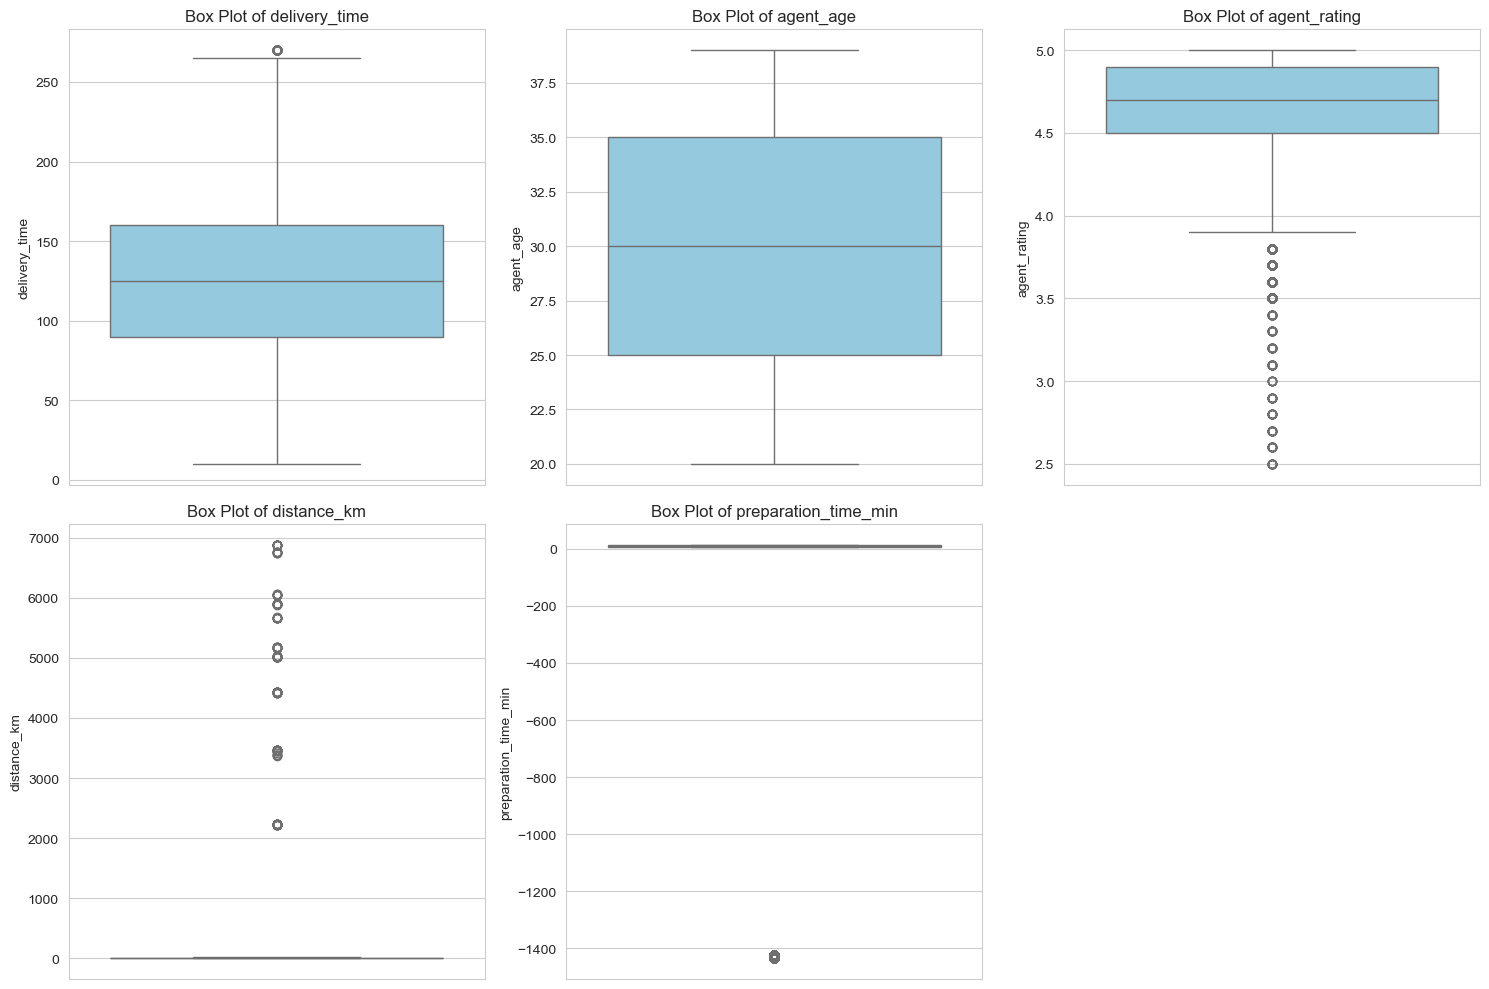

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Select the key numerical features where you want to check for outliers
numerical_features_to_check = [
    'delivery_time',
    'agent_age',
    'agent_rating',
    'distance_km',
    'preparation_time_min'
]

print("📊 Visualizing Outliers in Key Numerical Features...")
print("Data points shown as dots outside the main box whiskers are potential outliers.")

# Set the plotting style
sns.set_style('whitegrid')

# Create a figure to hold all the subplots
plt.figure(figsize=(15, 10))

# Loop through each numerical feature and create a box plot
for i, feature in enumerate(numerical_features_to_check):
    plt.subplot(2, 3, i + 1)  # Create a 2x3 grid of plots
    sns.boxplot(y=df[feature], color='skyblue')
    plt.title(f'Box Plot of {feature}')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

## Final Script with Outlier Features and MLflow Logging

In [13]:
import numpy as np
import pandas as pd
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# --- ASSUMPTIONS ---
# 1. 'df': Your cleaned DataFrame is available.
# 2. 'random_search': The fitted RandomizedSearchCV object from tuning is available.
# -------------------

# --- 1. Create New Features Based on Outlier Analysis ---

# Define outlier thresholds
prep_time_threshold = df['preparation_time_min'].quantile(0.95)
distance_threshold = df['distance_km'].quantile(0.95)
low_rating_threshold = 4.5

# Create binary flags for outlier conditions
df['is_long_prep_time'] = (df['preparation_time_min'] > prep_time_threshold).astype(int)
df['is_long_distance'] = (df['distance_km'] > distance_threshold).astype(int)
df['is_low_rating_agent'] = (df['agent_rating'] < low_rating_threshold).astype(int)

# Bin the agent_rating feature
def rating_to_category(rating):
    if rating >= 4.8:
        return 'Excellent'
    elif rating >= 4.5:
        return 'Good'
    else:
        return 'Needs_Improvement'
df['agent_rating_category'] = df['agent_rating'].apply(rating_to_category)

print("✅ New outlier-based features created.")

# --- 2. Define Final Feature Set ---
final_features = [
    'agent_age', 'preparation_time_min', 'distance_km',
    'weather', 'traffic', 'vehicle', 'category', 'area', 'is_weekend',
    'is_long_prep_time', 'is_long_distance', 'is_low_rating_agent',
    'agent_rating_category'
]
target = 'delivery_time'

X_final = df[final_features].copy()
y_final = df[target]

# --- 3. Rebuild Preprocessor and Train with MLflow ---
categorical_features = X_final.select_dtypes(include=['object']).columns
numerical_features = X_final.select_dtypes(include=np.number).columns

numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
preprocessor_final = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_features)
    ], remainder='passthrough'
)

X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_final, y_final, test_size=0.2, random_state=42)

best_params = random_search.best_params_
best_params_cleaned = {key.replace('regressor__', ''): value for key, value in best_params.items()}

final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_final),
    ('regressor', XGBRegressor(**best_params_cleaned, random_state=42, n_jobs=-1))
])

# --- MLflow Logging Integration ---
with mlflow.start_run(run_name="Outlier Feature Engineering") as run:
    print("\n🚀 Training final model with outlier-specific features and logging to MLflow...")

    # Log parameters for this run
    mlflow.log_param("feature_set_name", "outlier_features")
    mlflow.log_param("features", str(final_features))
    mlflow.log_param("prep_time_threshold_quantile", 0.95)
    mlflow.log_param("distance_threshold_quantile", 0.95)
    mlflow.log_param("low_rating_threshold", low_rating_threshold)

    # Train the model
    final_pipeline.fit(X_train_f, y_train_f)

    # Make predictions
    y_pred_f = final_pipeline.predict(X_test_f)

    # Calculate metrics
    r2_f = r2_score(y_test_f, y_pred_f)
    rmse_f = np.sqrt(mean_squared_error(y_test_f, y_pred_f))
    mae_f = mean_absolute_error(y_test_f, y_pred_f)

    # Log metrics
    mlflow.log_metric("rmse", rmse_f)
    mlflow.log_metric("mae", mae_f)
    mlflow.log_metric("r2_score", r2_f)

    # Log the model
    mlflow.sklearn.log_model(final_pipeline, "model_with_outlier_features")
    
    print("✅ Training and logging complete.")

    # --- 4. Evaluate Final Performance ---
    print("\n--- Previous Best Results (Tuned Model) ---")
    print(f"RMSE: 22.04 | MAE: 17.05 | R2 Score: 0.815")
    print("\n--- Final Model Results (With Outlier Features) ---")
    print(f"RMSE: {rmse_f:.2f} | MAE: {mae_f:.2f} | R2 Score: {r2_f:.3f}")

✅ New outlier-based features created.

🚀 Training final model with outlier-specific features and logging to MLflow...


2025/10/05 20:16:12 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/05 20:16:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Training and logging complete.

--- Previous Best Results (Tuned Model) ---
RMSE: 22.04 | MAE: 17.05 | R2 Score: 0.815

--- Final Model Results (With Outlier Features) ---
RMSE: 22.40 | MAE: 17.26 | R2 Score: 0.809


## 6. Saving the Champion Model for Deployment
Based on the MLflow experiments, we choose the best performing model, retrain it on the full dataset, and save it for our Streamlit application.

In [14]:
# From our MLflow runs, the tuned XGBoost on the BASE features performed best.
best_model_pipeline = random_search.best_estimator_

print("🎓 Training the final champion model on all training data...")
best_model_pipeline.fit(X, y) # Retraining on the full dataset (X, y)
print("✅ Final model is trained.")

model_filename = 'delivery_time_predictor.joblib'
joblib.dump(best_model_pipeline, model_filename)

print(f"\n🎉 Model successfully saved to '{model_filename}'.")


🎓 Training the final champion model on all training data...
✅ Final model is trained.

🎉 Model successfully saved to 'delivery_time_predictor.joblib'.
